In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree,DMatrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import ta as ta
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime

from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import *

from sklearn.preprocessing import MinMaxScaler

import pickle

def GetTsi(base,gaussian_knots,gaussian_sigma,ewm_span=20):
    
    tsi_config=[25,13]

    resultados_tsi = ta.momentum.TSIIndicator(base["Close"],tsi_config[0],tsi_config[1],False)

    tsi_df = pd.DataFrame(resultados_tsi.tsi())
    
    tsi_df.dropna(inplace=True)
    
    #Suavizando TSI com médias móveis exponenciais
    tsi_df["ewm"] = tsi_df['tsi'].ewm(span = ewm_span).mean()*1.2
    #------------------------------------------
    
    #Suavizanto TSI com gaussian smoother
    tsi_np = tsi_df["tsi"].to_numpy()
    tsi_np.reshape(1,len(tsi_np))

    smoother = GaussianSmoother(n_knots=gaussian_knots, sigma=gaussian_sigma)
    smoother.smooth(tsi_np)

    tsi_df["gaussian"] = smoother.smooth_data[0]
    #------------------------------------------
    
    return tsi_df

def Normalizar(Oscilador,coluna):
    
    normalizador = MinMaxScaler(feature_range=(0,1))
    
    if coluna == "tsi":
        Oscilador_treinamento = Oscilador.iloc[:,0:1].values
        
    if coluna == "ewm":
        Oscilador_treinamento = Oscilador.iloc[:,1:2].values
        
    if coluna == "gaussian":
        Oscilador_treinamento = Oscilador.iloc[:,2:3].values
        
    Oscilador_normalizado = normalizador.fit_transform(Oscilador_treinamento)
    
    return Oscilador_normalizado


def Realizar_previsoes_XGBoost(qtd_previsoes,base,anteriores,modelo,knots=60,sigma=0.0003):


    ultimos_valores = base.tail(anteriores+37)

    tsi_atual = GetTsi(ultimos_valores,knots,sigma)

    normalizado = Normalizar(tsi_atual,"gaussian")

    x_reshape =normalizado.reshape(1,-1)

    lista_previsoes = list()

    i = 0

    while i < qtd_previsoes:
        
        previsao = modelo.predict(x_reshape)

        lista_previsoes.append(previsao)

        x_reshape =  np.append(x_reshape,previsao)

        x_reshape = np.delete(x_reshape,0)

        x_reshape =x_reshape.reshape(1,-1)

        i+=1
        
    return lista_previsoes


def Carregar_modelo_XGBoost(filepath):
    
    pickled_model = pickle.load(open(filepath, 'rb'))
    
    return pickled_model

[*********************100%***********************]  1 of 1 completed


<AxesSubplot: >

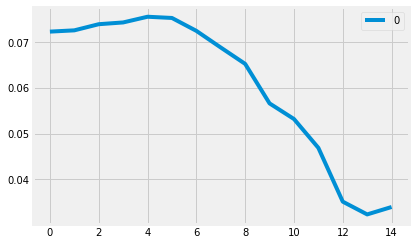

In [43]:
modelo = Carregar_modelo_XGBoost("Modelo_XGBoost_teste3.pkl")

ticker ="PETR3.SA"

df = yf.download(ticker)

base = df[:"2022-05-05"]

anteriores = 70
qtd_previsoes = 15
knots = 60
sigma = 0.0003

previsoes = Realizar_previsoes_XGBoost(qtd_previsoes,base,anteriores,modelo,knots=60,sigma=0.0003)

pd.DataFrame(previsoes).plot()